### How does the time of day that various citations tend to take take place at fluctuate throughout the year?

In [102]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pyodbc
import pandas as pd
import seaborn as sns
import datetime
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.0f}'.format

# databaseConnection = 'DRIVER={SQL Server}; SERVER=ServerName; Database=DatbaseName; UID=UserId; PWD=password;'
connection = pyodbc.connect('DRIVER={SQL Server};SERVER=WINDOWS-A6S01I2\SQLEXPRESS;DATABASE=City_of_Scottsdale;Trusted_Connection=yes;')
cursor = connection.cursor()

# SQL query to import all citation data
citations = '''
  select *
from [dbo].[spd_PDCitations$]
'''
citations = pd.read_sql(citations, connection)
connection.close()

citations['Month'] = citations['Citation Date'].dt.month
citations['Week'] = citations['Citation Date'].dt.week


In [3]:
citations.shape

(35752, 24)

In [5]:
citations.head()

,tcmainid,Citation #,Citation Date,Citation Time,Arizona Statute Code,Charge Description,Citation Type Code,Citation Type Description,Officer Badge #,Street Number,Street,City,State,Zip,District,Beat,Zone,Cited Person,Cited Person Age,Cited Person Race,Cited Person Sex,Cited Person Ethnicity,Month,Week
0,621784,2065379,2018-06-23,204,13-1203A1,Assault-Intentional/Recklessly Injure,CR,Criminal,1489,1xxx,N Granite Reef Rd,Scottsdale,AZ,nan,D1,2,412,"Hill, Julie",25,I,F,N,6,25
1,621797,2063172,2018-06-23,928,13-3415A,Drug Paraphernalia-Possess/Use,CR,Criminal,1214,7xxx,N Hayden Rd,Scottsdale,AZ,nan,D3,10,2504,"Mc Cuan, Michael",51,W,M,N,6,25
2,621806,2056700,2018-06-23,1053,28-701A,Failure to Control Speed to Avoid A Collision,CV,Civil Traffic,1360,xxx,E Indian Bend Rd / N Scottsdale Rd,Scottsdale,AZ,nan,D3,10,2501,"Glasscock, James",60,W,M,N,6,25
3,621847,2050143,2018-06-23,2345,19-19A,Urinate/Defecate In Public,MC,Municipal Code,1345,4xxx,N Saddlebag Tr,Scottsdale,AZ,nan,D2,6,904,"Still, Marcus",22,B,M,N,6,25
4,621878,2063174,2018-06-24,927,28-3473A,Suspended/Revoked D.L.,CT,Criminal Traffic,1214,8xxx,E McDonald DR,Scottsdale,AZ,nan,D2,8,2205,"Chacon, Kimberly",48,W,F,N,6,25


In [79]:
print(citations['Citation Date'].max())
print(citations['Citation Date'].min())

2019-02-10 00:00:00
2017-09-23 00:00:00


In [148]:
citations_of_interest = [
    'Exceed 15mph In School Crossing',
    'Speed Greater Than R&P or Posted',
    'Failure to Control Speed to Avoid A Collision',
]

citations_of_interest_extremes = [
    'DUI-Impaired to Slightest Degree',
    'Liquor-Under 21 Any Liquor In Body'
]

In [149]:
# filter for only 2018 data
citations_2018 = citations[(citations['Citation Date'] >= '2018-01-01') & 
                          (citations['Citation Date'] <= '2018-12-31')]

# further filter to only citations I'm specifically interested in
citations_2018_filtered = citations_2018[citations_2018['Charge Description'].isin(citations_of_interest)]

# separate out citations that regularly take place very late in the evening or early in the morning
citations_2018_filtered_extremes = citations_2018[citations_2018['Charge Description'].isin(citations_of_interest_extremes)]

citations_2018_filtered_grouped = citations_2018_filtered.groupby(['Charge Description', 'Week'])['Citation Time'] \
    .agg(['mean','count']) \
    .sort_values(by='Week', ascending=False) \
    .reset_index()

citations_2018_filtered_grouped_extremes = citations_2018_filtered_extremes.groupby(['Charge Description', 'Week'])['Citation Time'] \
    .agg(['mean','count']) \
    .sort_values(by='Week', ascending=False) \
    .reset_index()

In [165]:
print(citations_2018['Citation Date'].max())
print(citations_2018['Citation Date'].min())

2018-12-31 00:00:00
2018-01-01 00:00:00


In [161]:
citations_2018_filtered_grouped.set_index('Charge Description', inplace=True)
citations_2018_filtered_grouped_extremes.set_index('Charge Description', inplace=True)

,Week,mean,count
Charge Description,,,
Speed Greater Than R&P or Posted,52,1352,59
Failure to Control Speed to Avoid A Collision,52,1387,12
Failure to Control Speed to Avoid A Collision,51,1312,19
Exceed 15mph In School Crossing,51,1092,2
Speed Greater Than R&P or Posted,51,1207,85


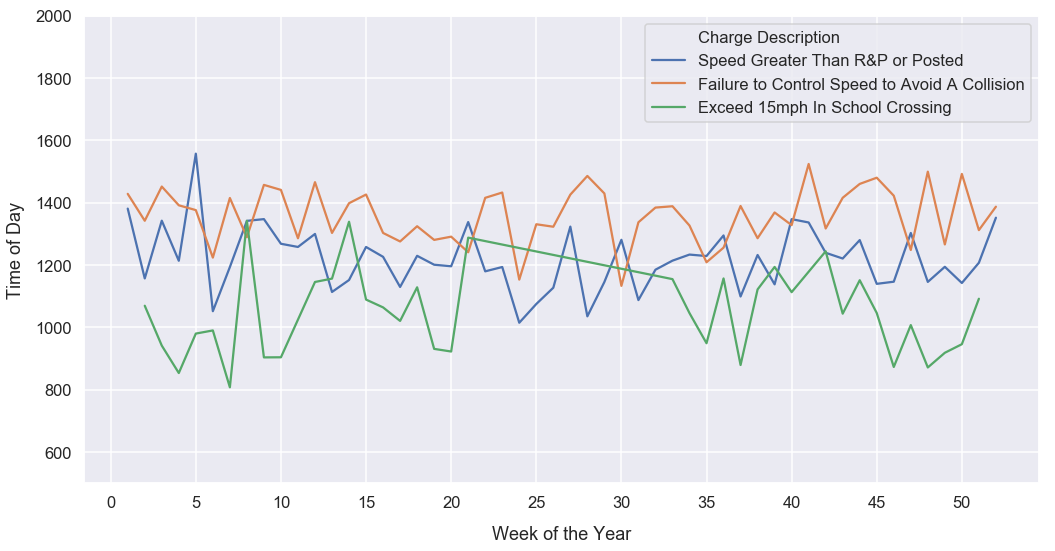

In [156]:
sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('talk')
plt.ylim(500,2000)

ax = sns.lineplot(x=citations_2018_filtered_grouped.iloc[:,0], 
                  y=citations_2018_filtered_grouped.iloc[:,1], 
                  data=citations_2018_filtered_grouped, 
                 hue=citations_2018_filtered_grouped.index)

# plt.title("")
plt.xlabel("Week of the Year", labelpad=15)
plt.ylabel("Time of Day", labelpad=10)

ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(5))
plt.tight_layout()

#### Above: Citations for speeding in school crossing zones will be enforced at specific times in the morning and afternoon, it makes sense that this citation will be more widely dispersed than the other two

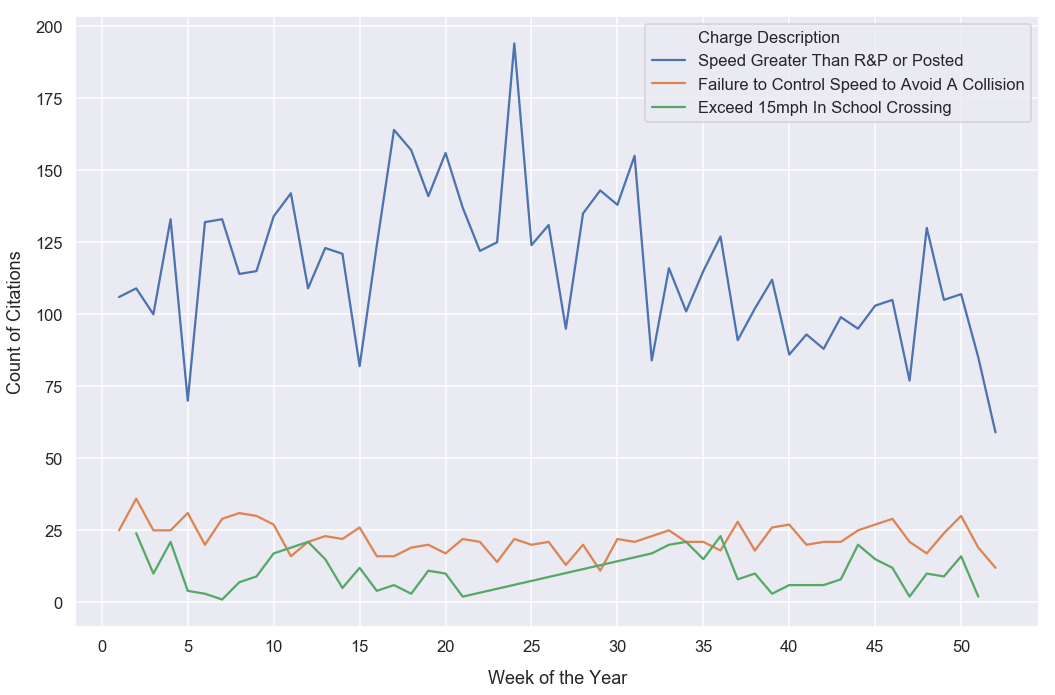

In [153]:
sns.set(rc={'figure.figsize':(15,10)})
sns.set_context('talk')
ax = sns.lineplot(x=citations_2018_filtered_grouped.iloc[:,0], 
                  y=citations_2018_filtered_grouped.iloc[:,2], 
                  data=citations_2018_filtered_grouped, 
                 hue=citations_2018_filtered_grouped.index)

# plt.title("")
plt.xlabel("Week of the Year", labelpad=15)
plt.ylabel("Count of Citations", labelpad=10)

ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(5))
plt.tight_layout()

#### Above: It's not clear to me why the count of speeding citations increases slightly in the summer.

## Count and variance of alcohol related citations throughout the year

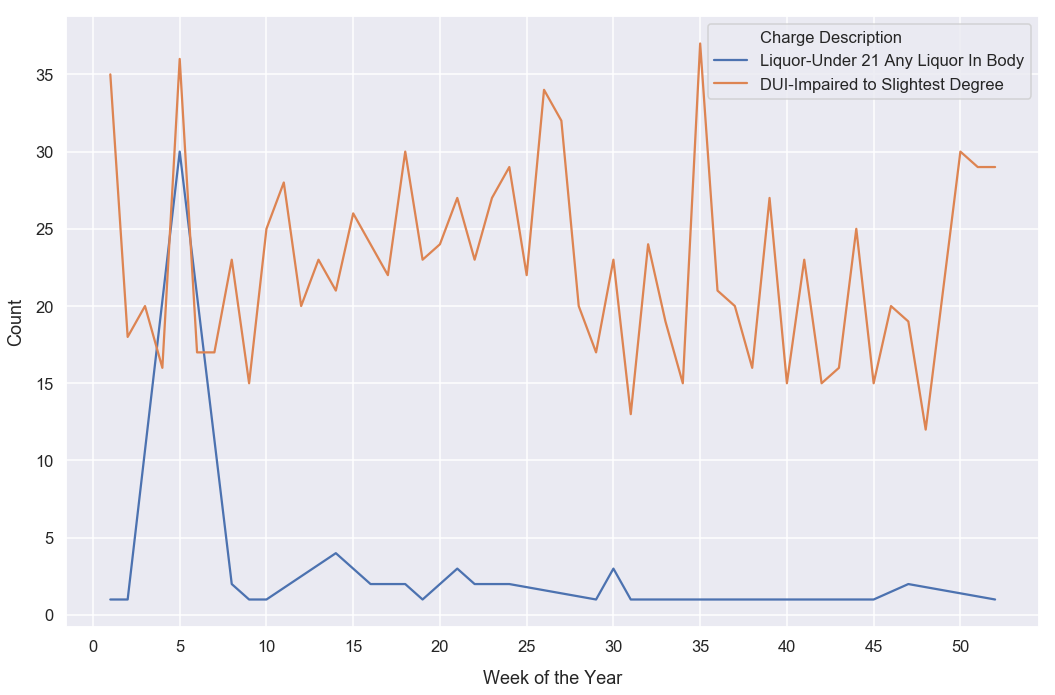

In [164]:
sns.set(rc={'figure.figsize':(15,10)})
sns.set_context('talk')

ax = sns.lineplot(x=citations_2018_filtered_grouped_extremes.iloc[:,0],
                  y=citations_2018_filtered_grouped_extremes.iloc[:,2],
                  data=citations_2018_filtered_grouped_extremes,
                 hue=citations_2018_filtered_grouped_extremes.index)

# plt.title("")
plt.xlabel("Week of the Year", labelpad=15)
plt.ylabel("Count", labelpad=10)

ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(5))
plt.tight_layout()

#### Above: The large spike in underage drinking and DUIs at the 5th week of the year is due to the Waste Management Golf Tournament.  The large spike of DUI citations at week 35 is likely due to Labor Day.

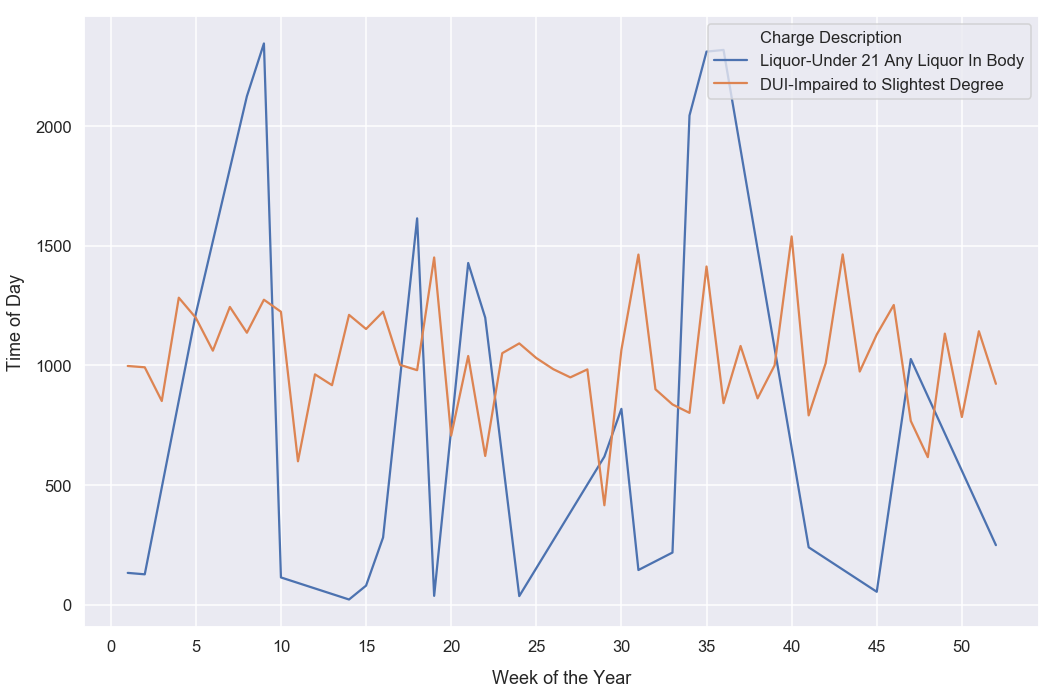

In [163]:
sns.set(rc={'figure.figsize':(15,10)})
sns.set_context('talk')

ax = sns.lineplot(x=citations_2018_filtered_grouped_extremes.iloc[:,0],
                  y=citations_2018_filtered_grouped_extremes.iloc[:,1],
                  data=citations_2018_filtered_grouped_extremes,
                 hue=citations_2018_filtered_grouped_extremes.index)

plt.xlabel("Week of the Year", labelpad=15)
plt.ylabel("Time of Day", labelpad=10)

ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(5))
plt.tight_layout()

#### Above: The large up and down of these two citation types is due to the fact that they take place either late at night, or early in the morning.  Because of a smaller population size, the underage drinking citation will be more sensitive to fluctuations.